<a href="https://colab.research.google.com/github/rabya321/ML/blob/main/trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import io



In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from google.colab import files
uploaded = files.upload()

dataframes = [pd.read_csv(io.BytesIO(f)) for f in uploaded.values()]
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv('merged_final.csv', index=False)
print("Merged file saved as 'merged_final.csv'")



Using device: cuda


Saving Recording_1_ReVSTED.csv to Recording_1_ReVSTED.csv
Saving Recording_2_ReVSTED.csv to Recording_2_ReVSTED.csv
Saving Recording_3_ReVSTED.csv to Recording_3_ReVSTED.csv
Saving Recording_4_ReVSTED.csv to Recording_4_ReVSTED.csv
Saving Recording_5_ReVSTED.csv to Recording_5_ReVSTED.csv
Saving Recording_6_ReVSTED.csv to Recording_6_ReVSTED.csv
Saving Recording_7_ReVSTED.csv to Recording_7_ReVSTED.csv
Merged file saved as 'merged_final.csv'


In [ ]:
# Calculate deltas in the vehicle frame
df = pd.read_csv('merged_final.csv')
dt = 1 / 50  # 50Hz
df['delta_x_v'] = df['ins_vel_hor_x'] * dt
df['delta_y_v'] = df['ins_vel_hor_y'] * dt
print("Deltas calculated.")

seq_len = 75

# Input and target columns
input_columns = ['SW_pos_obd', 'brake_pressure_obd', 'LatAcc_obd', 'speedo_obd',
                 'VelFR_obd', 'VelFL_obd', 'VelRR_obd', 'VelRL_obd', 'Yawrate_obd', 'ins_yaw']
target_columns = ['ins_vel_hor_x', 'ins_vel_hor_y', 'delta_x_v', 'delta_y_v']

# Split dataset
train_size = int(0.7 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

# Scaling inputs and targets
input_scaler = StandardScaler().fit(train_data[input_columns].values)
target_scaler = StandardScaler().fit(train_data[target_columns].values)
print("Data split and scaled.")

# Dataset class
class SingleStepDataset(Dataset):
    def __init__(self, data, input_columns, target_columns, seq_len, input_scaler, target_scaler):
        self.seq_len = seq_len
        inputs = data[input_columns].values
        targets = data[target_columns].values
        self.inputs = input_scaler.transform(inputs)
        self.targets = target_scaler.transform(targets)

    def __len__(self):
        return len(self.inputs) - self.seq_len

    def __getitem__(self, idx):
        x = self.inputs[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = SingleStepDataset(train_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
val_dataset = SingleStepDataset(val_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
test_dataset = SingleStepDataset(test_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Data loaded into DataLoaders.")

# LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Hyperparameters
input_size = len(input_columns)
hidden_size = 64
num_layers = 3
output_size = len(target_columns)
dropout = 0.2
learning_rate = 0.0005
weight_decay = 1e-5
epochs = 50
patience = 10

# Initialize model, loss, optimizer
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_val_loss = np.inf
early_stopping_counter = 0
print("Model initialized.")



NameError: name 'pd' is not defined

In [ ]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            predictions = model(x_val)
            loss = criterion(predictions, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved at epoch {epoch+1}.")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/50 - Train Loss: 0.0741, Val Loss: 0.0120
Best model saved at epoch 1.
Epoch 2/50 - Train Loss: 0.0603, Val Loss: 0.0180
Epoch 3/50 - Train Loss: 0.0558, Val Loss: 0.0102
Best model saved at epoch 3.
Epoch 4/50 - Train Loss: 0.0500, Val Loss: 0.0096
Best model saved at epoch 4.
Epoch 5/50 - Train Loss: 0.0461, Val Loss: 0.0101
Epoch 6/50 - Train Loss: 0.0421, Val Loss: 0.0092
Best model saved at epoch 6.
Epoch 7/50 - Train Loss: 0.0400, Val Loss: 0.0092
Epoch 8/50 - Train Loss: 0.0373, Val Loss: 0.0115
Epoch 9/50 - Train Loss: 0.0361, Val Loss: 0.0106
Epoch 10/50 - Train Loss: 0.0342, Val Loss: 0.0082
Best model saved at epoch 10.
Epoch 11/50 - Train Loss: 0.0335, Val Loss: 0.0111
Epoch 12/50 - Train Loss: 0.0314, Val Loss: 0.0095
Epoch 13/50 - Train Loss: 0.0310, Val Loss: 0.0114
Epoch 14/50 - Train Loss: 0.0291, Val Loss: 0.0106
Epoch 15/50 - Train Loss: 0.0285, Val Loss: 0.0110
Epoch 16/50 - Train Loss: 0.0287, Val Loss: 0.0108
Epoch 17/50 - Train Loss: 0.0267, Val Loss: 0.0

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()
print("Best model loaded.")

# Predictions
preds, targets = [], []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        pred = model(x_test).cpu().numpy()
        preds.append(pred)
        targets.append(y_test.numpy())
preds = np.concatenate(preds, axis=0)
targets = np.concatenate(targets, axis=0)
preds_unscaled = target_scaler.inverse_transform(preds)
targets_unscaled = target_scaler.inverse_transform(targets)



Best model loaded.



--- ins_vel_hor_x ---
MSE : 0.0182
RMSE: 0.1351
MAE : 0.0739
R²  : 0.9978


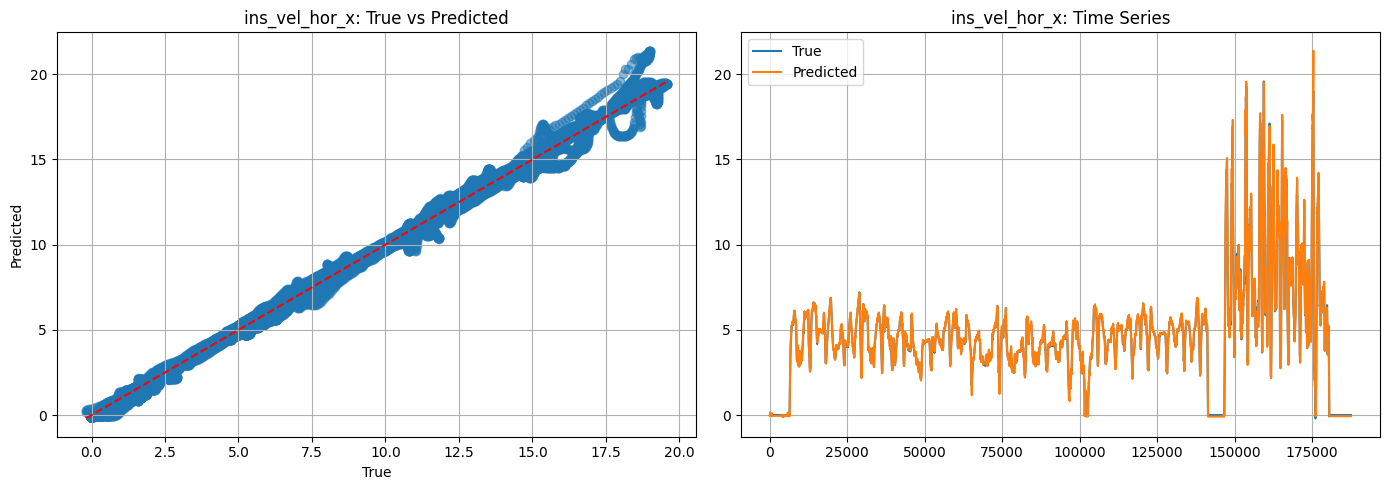


--- ins_vel_hor_y ---
MSE : 0.0012
RMSE: 0.0341
MAE : 0.0125
R²  : 0.8941


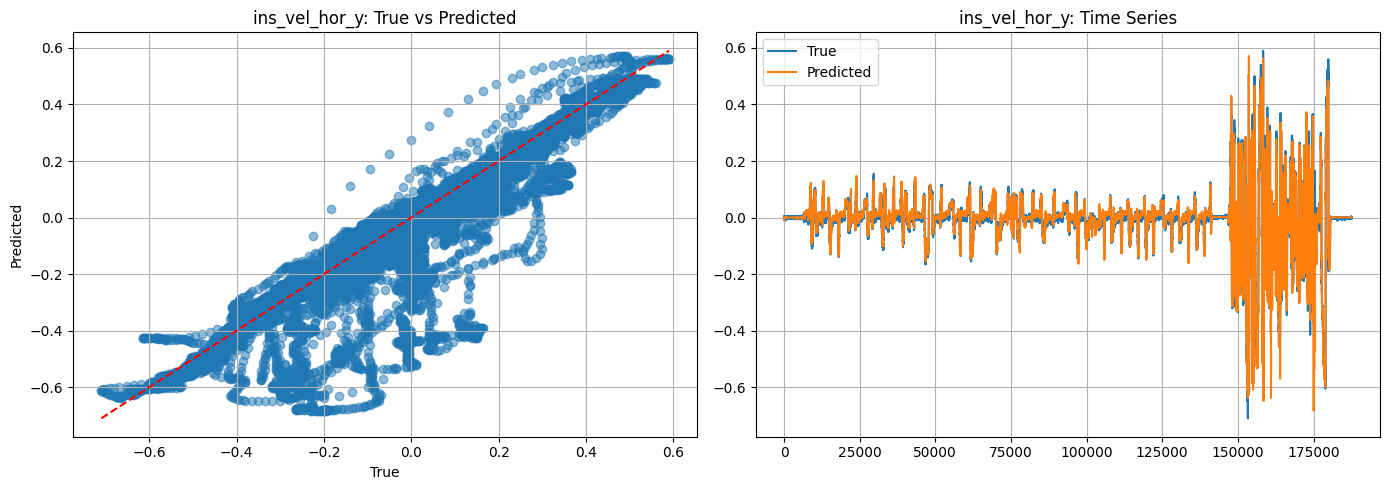


--- delta_x_v ---
MSE : 0.0000
RMSE: 0.0027
MAE : 0.0015
R²  : 0.9978


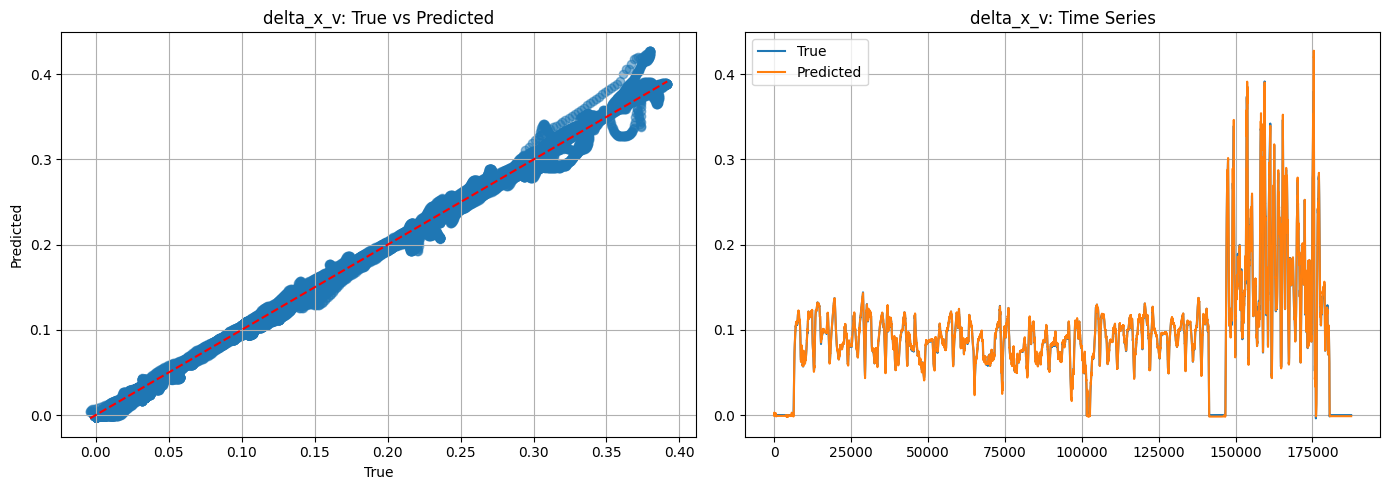


--- delta_y_v ---
MSE : 0.0000
RMSE: 0.0007
MAE : 0.0003
R²  : 0.8939


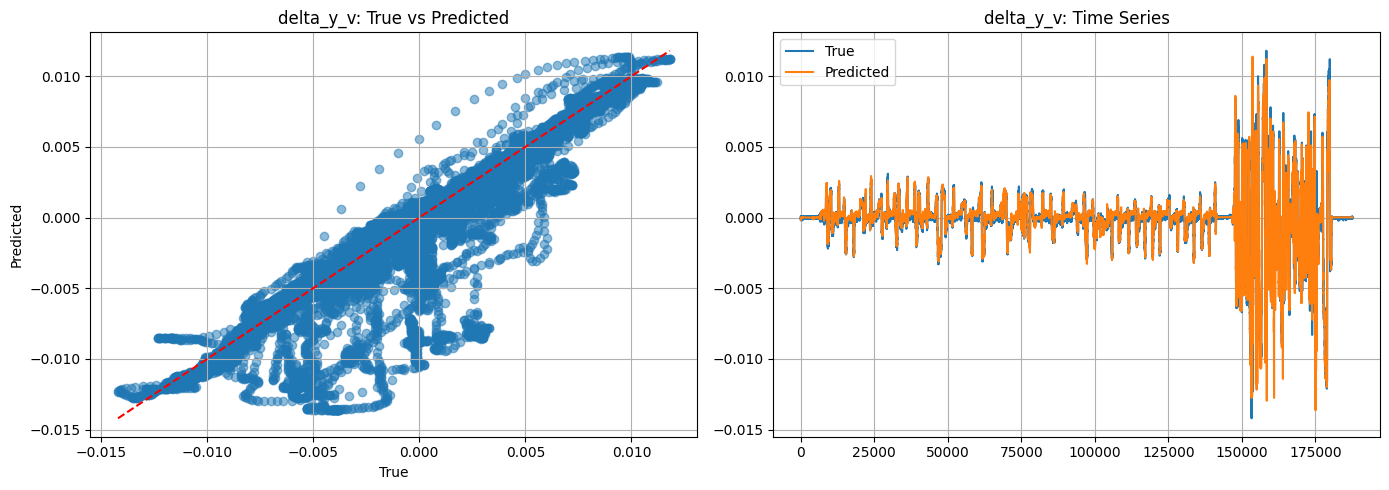

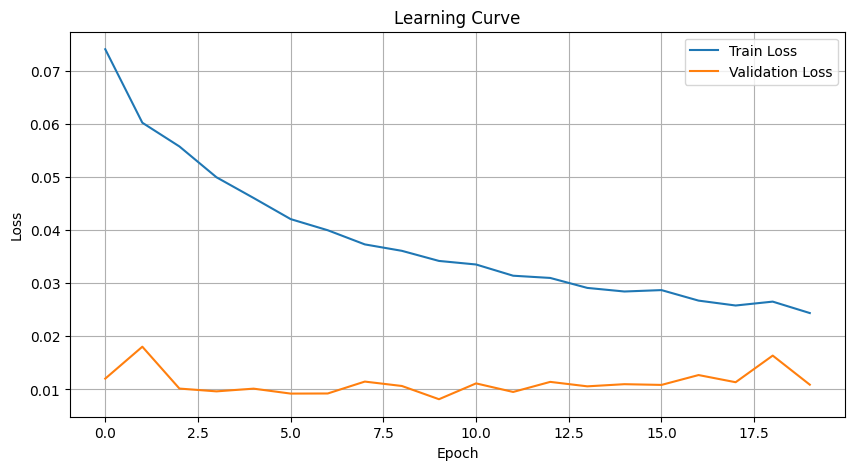

In [ ]:
# Metrics and plots
metrics = {}
for i, name in enumerate(target_columns):
    y_true = targets_unscaled[:, i]
    y_pred = preds_unscaled[:, i]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    print(f"\n--- {name} ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0].set_title(f'{name}: True vs Predicted')
    axes[0].set_xlabel('True')
    axes[0].set_ylabel('Predicted')
    axes[0].grid(True)

    axes[1].plot(y_true, label='True')
    axes[1].plot(y_pred, label='Predicted')
    axes[1].set_title(f'{name}: Time Series')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()



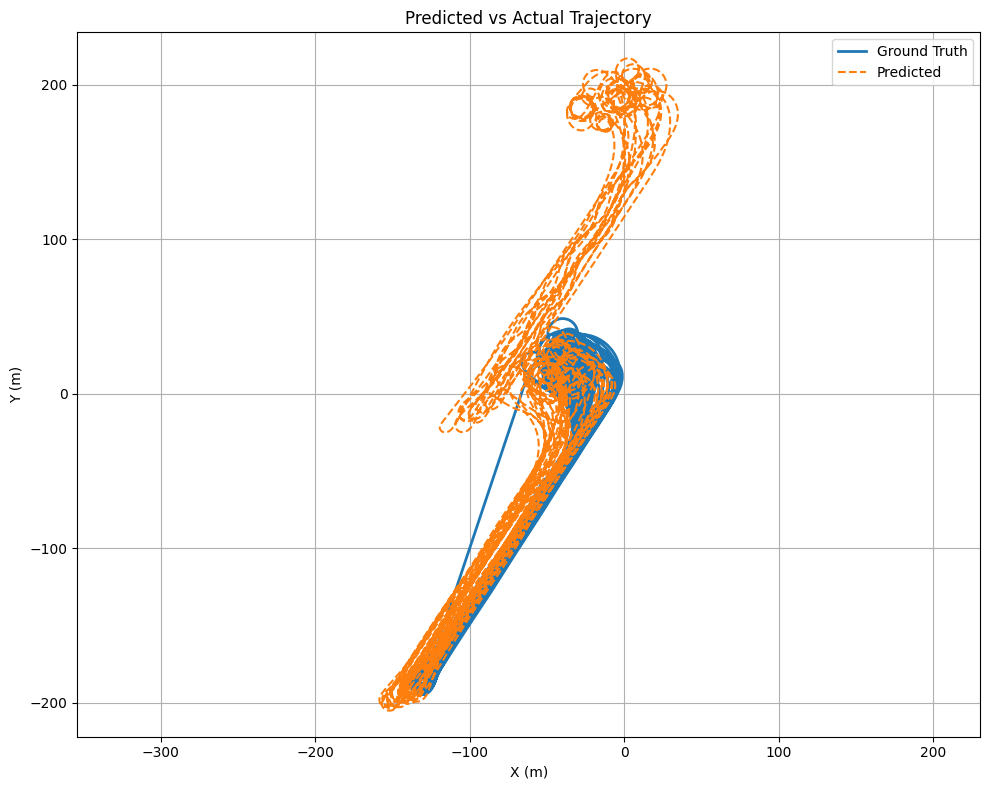

In [ ]:
# Trajectory reconstruction
yaw = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
yaw = -np.deg2rad(yaw)
pred_dx_v = preds_unscaled[:, 2]
pred_dy_v = preds_unscaled[:, 3]
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y
gt_pos_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
gt_pos_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]

plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted', linestyle='--')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()
